# PACKAGES

In [3]:
import numpy as np
from numpy import asarray
from PIL import Image
import os, random

import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams


from sklearn.metrics import confusion_matrix

# CODE

In [17]:

def ProcessImages(image_directory, process_every_n=8, thresh=110, padding_size=0, new_size=None, vita=5):

    #Creazione della cartella Binarized
    binarized_directory = os.path.join(image_directory, "Binarized")
    if not os.path.exists(binarized_directory):
        os.makedirs(binarized_directory)

    #Creazione della cartella Padded se specificato un valore di padding
    if padding_size > 0:
        padded_directory = os.path.join(image_directory, "Padded")
        if not os.path.exists(padded_directory):
            os.makedirs(padded_directory)

    #Creazione della cartella Diagrams
    diagram_directory = os.path.join(image_directory, "Diagrams")
    if not os.path.exists(diagram_directory):
        os.makedirs(diagram_directory)

    #Inizializzo gli array True/Predicted labels che utilizzerò per la matrice
    #di confusione
    true_labels = []
    predicted_labels = []

    # Ciclo su ogni elemento della directory in input
    for i, filename in enumerate(os.listdir(image_directory)):

        # Verifico che l'elemento sia l'immagine corretta
        if filename.endswith(".jpg") and (i % process_every_n == 0) and filename.endswith(".jpg"):
            #Apro l'immagine usando PIL e converto in scala di grigi
            img = Image.open(os.path.join(image_directory, filename))
            img = img.convert('L')
            #print(asarray(img))

            #Faccio un resize dell'immagine se richiesto in input
            if new_size:
                img = img.resize(new_size)


                                       #BINARIZZAZIONE
            #Binarizzo l'immagine secondo il valore di threshold in input
            #I pixel assumono valore da 0 (neri) a 255 (bianchi)
            binary_img = Image.new('L', img.size)

            for i in range(img.size[0]):
                for j in range(img.size[1]):
                    #Se il pixel ha valore inferiore a thresh gli assegno valore 0
                    #Se il pixel ha valore superiore a thresh gli assegno valore 255
                    if img.getpixel((i, j)) < thresh:
                        binary_img.putpixel((i, j), 0)
                    else:
                        binary_img.putpixel((i, j), 255)


            #print(asarray(binary_img))

            #Salvo l'immagine binarizzata nella rispettiva cartella
            img = binary_img
            binary_img.save(os.path.join(binarized_directory, "binarized_" + filename))

                                     #AGGIUNTA DI UN BORDO
            #Aggiungo un bordo se richiesto in input
            if padding_size > 0:
                #Size attuale dell'immagine binarizzata
                width, height = binary_img.size

                #Creo una nuova immagine nera (solo 0) con size desiderata
                pad_img = Image.new('L', (width + 2 * padding_size, height + 2 * padding_size), 0)

                #Incollo l'immagine originale sulla nuova immagine creata
                for i in range(width):
                    for j in range(height):
                        pixel = img.getpixel((i, j))
                        pad_img.putpixel((i + padding_size, j + padding_size), pixel)
                #print(asarray(new_img))

                #Salvo l'immagine con bordo nella rispettiva cartella
                img = pad_img
                pad_img.save(os.path.join(padded_directory, "padded_" + filename))


                                     #OMOLOGIA PERSISTENTE
            #Inizializzo la lista dei punti su cui andrò a calcolare la persistenza.
            #Ciclo su ogni pixel e memorizzo gli indici i,j dei punti di valore 0 (nero)
            #Ciò costituisce il dataset, di cui vogliamo determinare l'omologia persistente
            points = []
            for i in range(img.size[0]):
                for j in range(img.size[1]):
                    if img.getpixel((i, j)) == 0:
                        points.append((i, j))
            #print(points)


            #Converto la lista in array perchè ripser non prende in input liste
            points = np.array(points)
            #Ottenimento dei diagrammi di persistenza fermandomi al primo gruppo di omologia
            diagrams = ripser(points, maxdim=1)['dgms']  #coeff2 o meno, il risultato è lo stesso e non so la velocità
            #print(diagrams)


                           #CRITERIO DISCRIMINATORIO PER CLASSIFICAZIONE
            #Inizializzo la variabile "contatore"
            num_holes = 0
            #Considero solo il primo gruppo di omologia persistente
            diagrams1 = diagrams[1]
            #print(diagrams1)


            for i in range(diagrams1.shape[0]):
                #Determino la differenza tra morte e vita di ogni elemento
                diff = diagrams1[i][1] - diagrams1[i][0]
                #Se la differenza è maggiore del tempo di vita in input, aumento il contatore
                #Tengo conto del numero di H1 che presentano lunga vita
                if diff > vita:
                    num_holes += 1
                    #print(diagrams1[i][1], diagrams1[i][0], diff)
            #print(num_holes)


                          #GRAFICI DIAGRAMMI DI PERSISTENZA

            plot_diagrams(diagrams, show=False)
            #Aggiungo la retta y=x+vita per evidenziare meglio la soglia di discriminazione
            x = np.linspace(-10, max(points.max(0))+10, 100)
            y = x+vita
            plt.plot(x, y, c='red', label='y=x+'+str(vita))

            plt.legend()
            plt.savefig(os.path.join(diagram_directory, f"{filename.split('.')[0]}.png"))
            plt.clf()

                              #CLASSIFICAZIONE
            #Assegno le etichette reali
            #Se l'immagine è nella cartella "Positive" assegno valore 1
            true_label = 1 if "Positive" in image_directory else 0
            true_labels.append(true_label)

            #Assegno le etichette predette
            #Se presenta almeno 2 gruppi H1 di lunga vita, almeno due buchi persistenti
            #predico ci sia una crepa e assegno 1
            predicted_label = 1 if num_holes >= 2 else 0
            predicted_labels.append(predicted_label)

            #Stampo il nome delle immagini che sono falsi negativi/positivi
            if "Positive" in image_directory and num_holes < 2:
                print(f"{filename} è un falso negativo")
            if "Negative" in image_directory and num_holes >= 2:
                print(f"{filename} è un falso positivo")

    return true_labels, predicted_labels

# TO RANDOMIZE PREVIOUS CODE (OPTIONAL, used for cross validation)

In [ ]:
#TO RANDOMIZE THE PREVIOUS CODE JUST RUN THIS INSTEAD OF LINES 26-32
    # Creo una lista di tutti i file immagine nella directory che soddisfano la condizione i%8!=0
    filenames = [filename for i, filename in enumerate(os.listdir(image_directory)) if filename.endswith(".jpg") and (i% process_every_n!=0)]

    # Se ci sono meno di 2500 immagini nella lista, considero tutte le immagini
    if len(filenames) < 2500:
        selected_filenames = filenames
    else:
        # Altrimenti seleziono casualmente 2500 immagini dalla lista
        selected_filenames = random.sample(filenames, 2500)
    # Ciclo su ogni elemento selezionato della directory in input
    for filename in selected_filenames:
        # Apro l'immagine usando PIL e converto in scala di grigi
        img = Image.open(os.path.join(image_directory, filename))
        img = img.convert('L')


# RUNNING CODE

In [18]:
#Definisco le cartelle da cui prendere le immagini
positive_img_dir = "Positive"
negative_img_dir = "Negative"

#Definisco gli array con le etichette reali e predette
#Li riempirò con i risultati sia delle immagini positive che negative
total_true_labels=[]
total_predicted_labels=[]

process_every_n=5000
thresh=110
padding_size=1
new_size=(48, 48)
vita=8
                      #POSITIVE
#Chiamo la funzione ProcessImages con la cartella delle crepe
positive_true_labels, positive_predicted_labels = ProcessImages(positive_img_dir,process_every_n, thresh, padding_size, new_size, vita)
#Aggiungo agli array inizializzati precedentemente i valori appena ottenuti
total_true_labels.extend(positive_true_labels)
total_predicted_labels.extend(positive_predicted_labels)

                      #NEGATIVE
#Chiamo la funzione ProcessImages con la cartella delle non crepe
negative_true_labels, negative_predicted_labels = ProcessImages(negative_img_dir,process_every_n, thresh, padding_size, new_size, vita)
#Aggiungo agli array inizializzati precedentemente i valori appena ottenuti
total_true_labels.extend(negative_true_labels)
total_predicted_labels.extend(negative_predicted_labels)

                  #MATRICE DI CONFUSIONE
#Calcolo la matrice di confusione mettendo in input le etichette predette e le etichette reali
#Per tutte le immagini, positive e negative
cm = confusion_matrix(total_true_labels, total_predicted_labels)
print(cm)

05001.jpg è un falso negativo
[[4 0]
 [1 3]]


<Figure size 640x480 with 0 Axes>

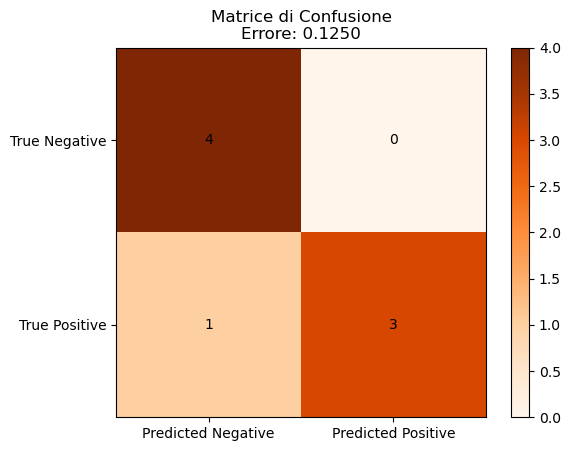

In [19]:
#Estraggo dalla matrice di confusione il numero di veri positivi/negativi e falsi positivi/negativi
true_pos = cm[1, 1]
true_neg = cm[0, 0]
false_pos = cm[0, 1]
false_neg = cm[1, 0]
#Calcolo l'errore sulle predizioni
error = (false_pos + false_neg) / (true_pos + true_neg + false_pos + false_neg)



                      #RAPPRESENTO GRAFICAMENTE LA MATRICE DI CONFUSIONE

fig, ax = plt.subplots()
im = ax.imshow(cm, cmap='Oranges')

#Imposto gli assi
ax.set_xticks(np.arange(len(cm)))
ax.set_yticks(np.arange(len(cm)))
ax.set_xticklabels(['Predicted Negative', 'Predicted Positive'])
ax.set_yticklabels(['True Negative', 'True Positive'])

# loop over data and add cell values to plot
for i in range(len(cm)):
    for j in range(len(cm)):
        text = ax.text(j, i, cm[i, j], ha='center', va='center', color='black')

#Imposto un titolo, aggiungo colorbar e salvo
ax.set_title(f'Matrice di Confusione\nErrore: {error:.4f}')
cbar = ax.figure.colorbar(im, ax=ax)
plt.savefig('confusion_matrix.jpg')
plt.show()
